In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

torch.normal       mean 0.0091593284 std 1.0016068220
torch.randn        mean 0.0043985425 std 0.9989724159
np.random.normal   mean -0.0089668351 std 1.0055132523


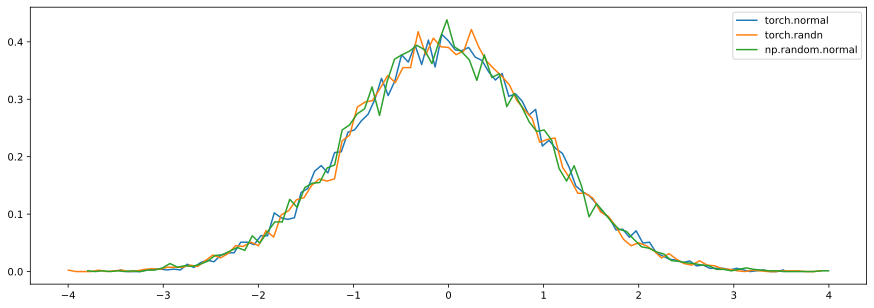

In [68]:
a = torch.normal(0, 1, (10000,))
b = torch.randn(10000)
c = torch.from_numpy(np.random.normal(0, 1, 10000))
data = {
    'torch.normal':a,
    'torch.randn':b,
    'np.random.normal':c
}


# plot the distribution of 3 function
p = plt.figure(figsize=(15,5))
for na, da in data.items():
    print(f"{na:18s} mean {da.mean():.10f} std {da.std():.10f}")
    hy, hx = torch.histogram(da, density=True)
    plt.plot(hx.detach()[:-1], hy, label=na)
    plt.legend()
plt.show()

In [69]:
# Create manual dataset
# y = w1x1 + w2x2 + b
torch.manual_seed(42)
num_inputs = 2
num_examples = 1000

true_w, true_b = [2, -3.4], 4.2 # true parameters
features = torch.randn(num_examples, num_inputs, dtype=torch.float) # 
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.normal(0, 0.01, labels.shape)   # add meaningless noise to dataset

print(features.shape, labels.shape)

torch.Size([1000, 2]) torch.Size([1000])


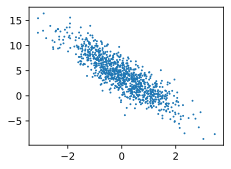

In [70]:
# show the relationship between labels and features
from d2lzh_pytorch import set_figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1)
plt.show()

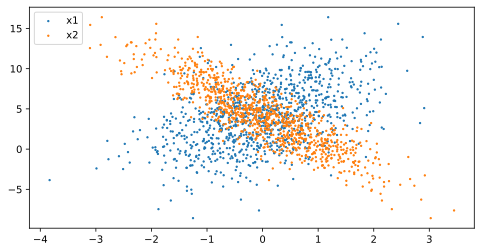

In [71]:
# my own code
p = plt.figure(figsize=(8, 4))
plt.scatter(features[:, 0], labels, 2, label='x1')
plt.scatter(features[:, 1], labels, 2, label='x2')
plt.legend()
plt.show()

In [72]:
from d2lzh_pytorch import data_iter

batch_size = 12
for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[ 1.2120, -1.3463],
        [-0.3427,  1.2370],
        [ 0.1932,  0.4097],
        [-0.2053, -1.4739],
        [ 1.4109, -1.3144],
        [ 0.9745,  0.4532],
        [ 0.7531, -0.2219],
        [ 0.3085, -0.4411],
        [-0.4834, -1.2261],
        [ 0.3267, -0.8344],
        [-0.1222, -0.7470],
        [-0.9291,  0.2762]])
tensor([11.1771, -0.6877,  3.2049,  8.8048, 11.4926,  4.6123,  6.4739,  6.3160,
         7.3949,  7.7014,  6.4916,  1.3941])


In [73]:
# Initialize weight
w = torch.normal(0, 1, (num_inputs, 1), dtype=torch.float, requires_grad=True)
w = w / 3 ** 0.5
w.retain_grad()
b = torch.zeros(1, dtype=torch.float, requires_grad=True)

print(w.shape, w.dtype, w.requires_grad)
print(b.shape, b.dtype, b.requires_grad)

torch.Size([2, 1]) torch.float32 True
torch.Size([1]) torch.float32 True


In [74]:
# Optimize
from d2lzh_pytorch import linreg, squared_loss, sgd

lr = 0.03
num_epoch = 3
net = linreg
loss = squared_loss
parameters = [w, b]

lossi = []
losse = []

for i in range(num_epoch):
    for X, y in data_iter(batch_size, features, labels): # Create an iterator
        out = net(X, w, b)
        losses = loss(out, y).mean()  # mean squared error
        lossi.append(losses.item())
        
        # backward
        for parameter in parameters:
            parameter.grad = None
        losses.backward(retain_graph=True)
        
        # sgd
        sgd(parameters, lr)
    train_l = loss(net(features, w, b), labels)
    losse.append(train_l.mean().item())
    print(f"epoch {i:5d}, loss {train_l.mean().item():10f}")
        

epoch     0, loss   0.103873
epoch     1, loss   0.000809
epoch     2, loss   0.000057


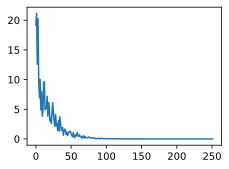

In [75]:
plt.plot(lossi)

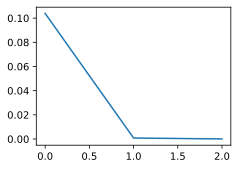

In [76]:
plt.plot(losse)

In [79]:
print(true_b)
print(true_w)

4.2
[2, -3.4]


In [102]:
print(b.item())
print(w.tolist())

4.197888374328613
[[1.9980820417404175], [-3.397846221923828]]


In [125]:
# Pytorch style 
class LinearNet(nn.Module):
    def __init__(self, fan_in, fan_out):
        super().__init__()
        self.linear = nn.Linear(fan_in, fan_out)    # weights are uniform distribution
    
    def forward(self, x):
        return self.linear(x)
    
net = LinearNet(2, 1)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [126]:
print(net.linear.weight)

Parameter containing:
tensor([[ 0.1144, -0.1652]], requires_grad=True)


In [127]:
for p in net.parameters():
    print(p.name, p.size(), p.requires_grad, p.data, p)

None torch.Size([1, 2]) True tensor([[ 0.1144, -0.1652]]) Parameter containing:
tensor([[ 0.1144, -0.1652]], requires_grad=True)
None torch.Size([1]) True tensor([-0.6476]) Parameter containing:
tensor([-0.6476], requires_grad=True)


In [128]:
print(net.parameters())

<generator object Module.parameters at 0x0000013ACBC2FD80>


In [129]:
net = nn.Sequential(
    nn.Linear(2, 1),
)
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


In [132]:
for p in net[0].parameters():
    print(p)

Parameter containing:
tensor([[0.3321, 0.5794]], requires_grad=True)
Parameter containing:
tensor([0.6045], requires_grad=True)


In [153]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, 0)

print(net[0].weight)
print("gard_fn: ", net[0].weight.grad_fn)
print(net[0].bias)
print("gard_fn: ", net[0].bias.grad_fn)

Parameter containing:
tensor([[0.0114, 0.0061]], requires_grad=True)
gard_fn:  None
Parameter containing:
tensor([0.], requires_grad=True)
gard_fn:  None


In [154]:
loss = nn.MSELoss()

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [158]:
import torch.utils.data as Data

# optimize 
num_epoch = 3
batch_size = 10
dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)
# for X, y in data_iter:
#     print(X)
#     print(y)
#     break

for i in range(num_epoch):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss %f' % (i + 1, l.item()))

epoch 1, loss 0.000279
epoch 2, loss 0.000116
epoch 3, loss 0.000037


In [159]:
print(true_w)
print(true_b)

[2, -3.4]
4.2


In [161]:
print(net[0].weight.tolist())
print(net[0].bias.item())

[[1.9989707469940186, -3.400519371032715]]
4.19965934753418
